## Import all required libraries

In [1]:
import ixmp
import message_ix
import numpy as np
import pandas as pd
import yaml

from collections.abc import Mapping
from itertools import repeat
from message_ix.models import MESSAGE_ITEMS
from message_ix.utils import make_df
from message_ix.tools.add_dac import *

%matplotlib inline

<IPython.core.display.Javascript object>

C:\Users\pratama\Documents\GitHub\MESSAGEix\message_ix\message_ix\reporting\__init__.py:98: FutureWarning: Importing from genno.computations will be deprecated in a future version; use genno.operator instead.
  ("tom:nl-t-yv-ya", (genno.computations.add, "fom:nl-t-yv-ya", "vom:nl-t-yv-ya")),


In [2]:
def plotvars(scenario):
    # CO2 Emission
    emiss = scenario.var("EMISS")
    emiss = emiss.loc[(emiss['type_tec'] == 'all') & 
                      (emiss['node'] == 'World') & 
                      (emiss['emission'] == 'TCE')]
    emiss_plot = emiss[['year','lvl']].set_index(['year']).div(1000)

    # CO2 Removal
    removal = scenario.var("EMISS")
    removal = removal.loc[(removal['type_tec'] == 'all') & 
                          (removal['node'] == 'World') & 
                          (removal['emission'] == 'CO2_storage')]
    removal_plot = removal[['year','lvl']].set_index(['year']).div(1000)

    # CO2 Prices
    CO2Price = (scenario.var("PRICE_EMISSION")
                .loc[scenario.var("PRICE_EMISSION")['type_emission'] == 'TCE'][['year','lvl']]
                .set_index(['year'])).div(1000)
    
    
    plt.figure(figsize=(4,4))
    # Plottings
    plt.plot(emiss_plot, label='CO2 Emission')
    plt.plot(removal_plot, label='CO2 Removal')
    plt.plot(CO2Price, label='CO2 Price')
    
    plt.ylim(-10,40)
    plt.ylabel("thousands of var unit")
    
    plt.legend()
    plt.show()

In [3]:
# REGIONAL CO2 STORAGE POTENTIAL
# read storage potential in GtCO2
potentials = pd.read_excel("storage_by_country.xlsx").set_index("ISO")

# read regional country lists
reg_list_path = "region_code_list.yaml"

with open(reg_list_path, 'r') as file:
    reg_data = yaml.safe_load(file)

# creating R12 potentials dataframe
R12_potential = pd.DataFrame(columns=["Potential"])

for reg in set(reg_data.keys()) - {"World"}:
    val = potentials.loc[reg_data[reg]["child"]]["Potential"].sum()
    R12_potential.loc[reg] = np.round(1000*val/3.667, 3) # convert to MtCO2
    
R12_pot = R12_potential.div(90)

In [4]:
R12_potential

,Potential
R12_LAM,55868.988
R12_EEU,1808.370
R12_PAO,34233.825
R12_RCPA,3754.285
R12_NAM,58983.981
R12_AFR,61399.222
R12_PAS,21108.578
R12_CHN,15712.475
R12_MEA,57369.171
R12_WEU,11793.358


In [5]:
# SSPs and scenarios lists
ssps = ["LED","SSP1","SSP2","SSP3","SSP4","SSP5"]
ssps = ["SSP1","SSP2","SSP5"]
ssps = ["LED","SSP1","SSP2","SSP4"]

max_rate = np.round(15000/3.667,0) # convert MtCO2/y to MtC/y



## Create baseline and emission bound scenarios with split CO2 infrastructure

In [6]:
parameters = {
    "LED":{
        "co2storage": 0.25,
        "co2rate"   : 4000/3.667,
        "dacupscale": 0.05,
        "daccost"   : [0.92,0.87,0.82,0.79,0.76,0.74,0.72,0.71,0.70,0.70,0.70,0.70],
        "dacenergy" : [0.92,0.87,0.82,0.79,0.76,0.74,0.72,0.71,0.70,0.70,0.70,0.70],
        "maxfco2sto": 1.0,
        "minfco2sto": 0.0,
    },
    "SSP1":{
        "co2storage": 0.25,
        "co2rate"   : 4000/3.667,
        "dacupscale": 0.05,
        "daccost"   : [0.92,0.87,0.82,0.79,0.76,0.74,0.72,0.71,0.70,0.70,0.70,0.70],
        "dacenergy" : [0.92,0.87,0.82,0.79,0.76,0.74,0.72,0.71,0.70,0.70,0.70,0.70],
        "maxfco2sto": 1.0,
        "minfco2sto": 0.0,
    },
    "SSP2":{
        "co2storage": 0.50,
        "co2rate"   : 9000/3.667,
        "dacupscale": 0.10,
        "daccost"   : [0.87,0.79,0.70,0.64,0.59,0.56,0.54,0.51,0.51,0.51,0.50,0.50],
        "dacenergy" : [0.87,0.79,0.70,0.64,0.59,0.56,0.54,0.51,0.51,0.51,0.50,0.50],
        "maxfco2sto": 1.0,
        "minfco2sto": 0.0,
    },
    "SSP3":{#
        "co2storage": 1.00,
        "co2rate"   : 15000/3.667,
        "dacupscale": 0.15,
        "daccost"   : [0.92,0.87,0.82,0.79,0.76,0.74,0.72,0.71,0.70,0.70,0.70,0.70], # <<<<< check
        "dacenergy" : [0.92,0.87,0.82,0.79,0.76,0.74,0.72,0.71,0.70,0.70,0.70,0.70], # <<<<< check
        "maxfco2sto": 1.0,
        "minfco2sto": 0.0,
    },
    "SSP4":{#
        "co2storage": 1.00,
        "co2rate"   : 15000/3.667,
        "dacupscale": 0.15,
        "daccost"   : [0.82,0.70,0.58,0.50,0.43,0.39,0.35,0.32,0.31,0.31,0.30,0.30],
        "dacenergy" : [0.82,0.70,0.58,0.50,0.43,0.39,0.35,0.32,0.31,0.31,0.30,0.30],
        "maxfco2sto": 1.0,
        "minfco2sto": 0.0,
    },
    "SSP5":{
        "co2storage": 1.00,
        "co2rate"   : 15000/3.667,
        "dacupscale": 0.15,
        "daccost"   : [0.82,0.70,0.58,0.50,0.43,0.39,0.35,0.32,0.31,0.31,0.30,0.30],
        "dacenergy" : [0.82,0.70,0.58,0.50,0.43,0.39,0.35,0.32,0.31,0.31,0.30,0.30],
        "maxfco2sto": 1.0,
        "minfco2sto": 0.5,
    },
    
}


**Scenarios without DAC**

LED objective value: 1919944.0
stor scenario: LED


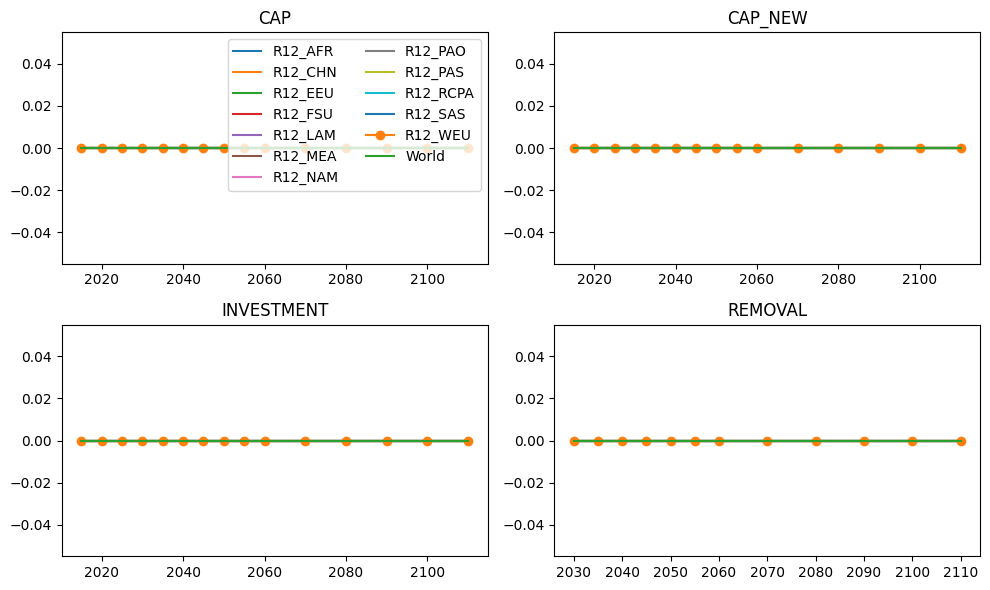

SSP1 objective value: 2286814.0
stor scenario: SSP1


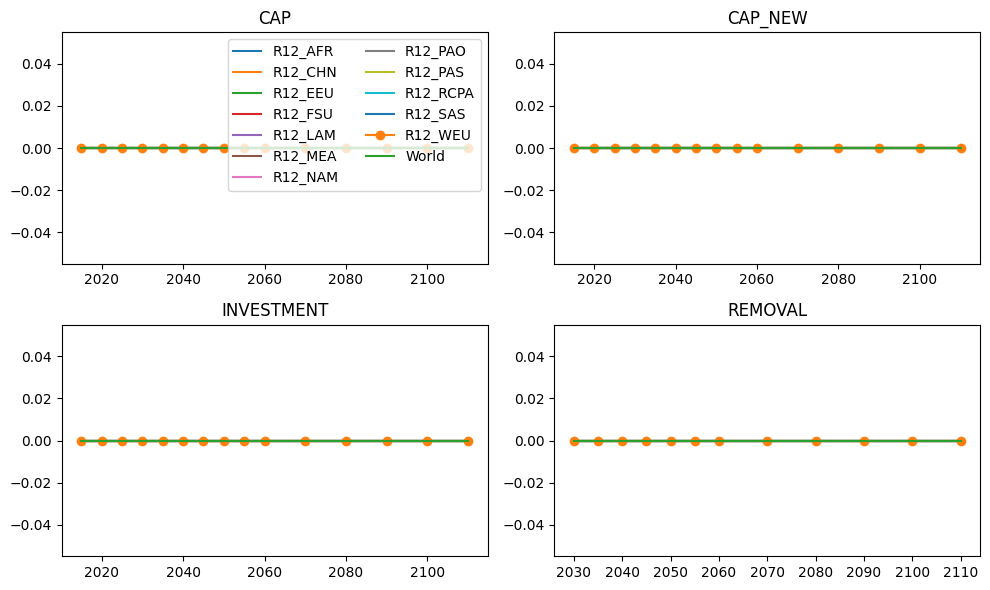

SSP2 objective value: 2826348.0
stor scenario: SSP2


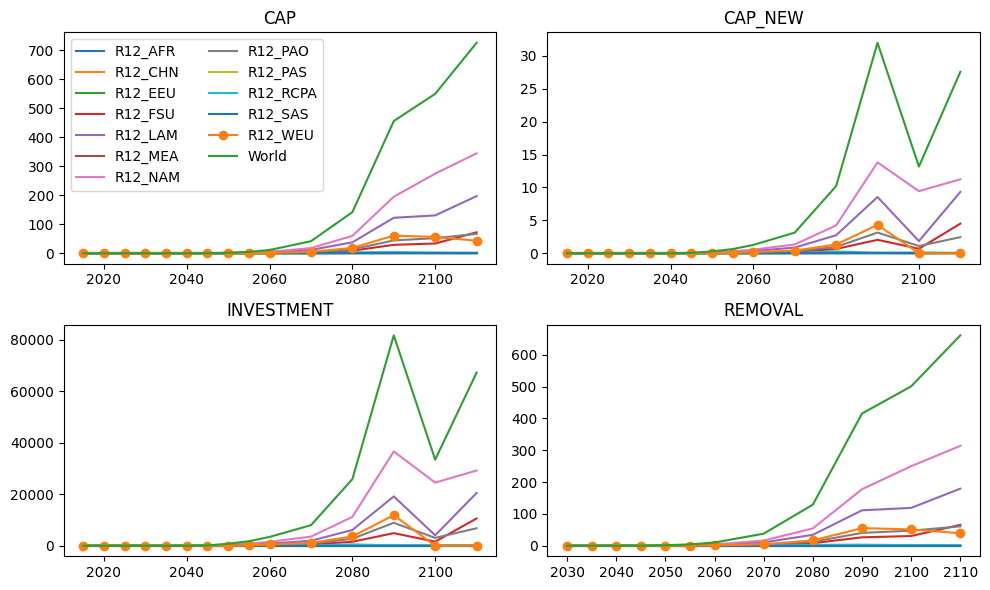

SSP4 objective value: 2690122.25
stor scenario: SSP4


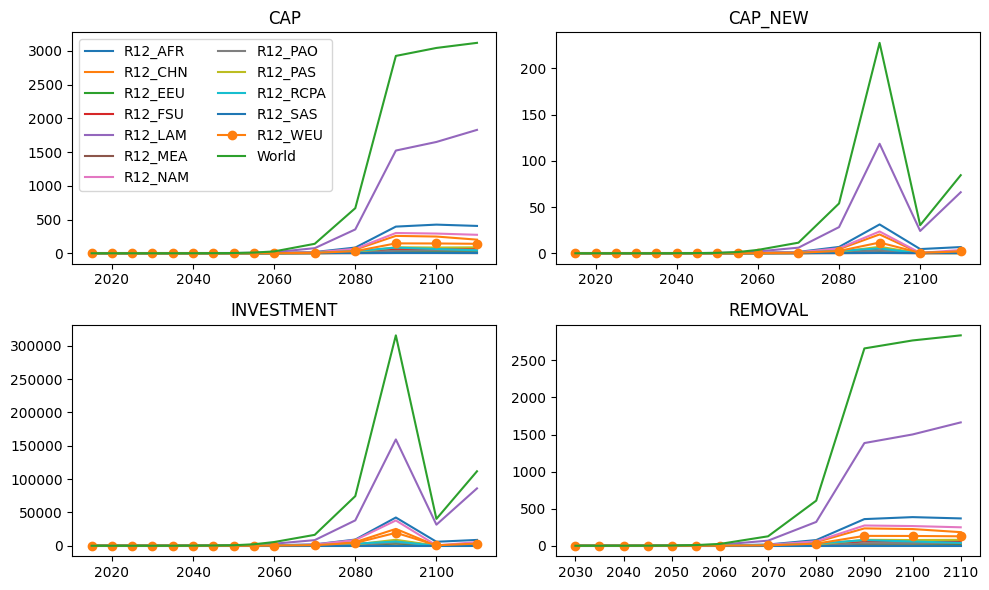

In [7]:
ssps = ["LED","SSP1","SSP2","SSP4"]

for ssp in ssps:
    mp = ixmp.Platform()

    sbase = message_ix.Scenario(mp, model=f"SSP_{ssp}_v1.0",
                                scenario="baseline_DEFAULT")
    
    s2run = sbase.clone(
        f"SSP_dev_{ssp}_v1.0_materials-dac-co2split",
        f"1000f_all-ssp-param",
        f"{ssp}_integrated_MESSAGE-Materials-DAC",
        keep_solution=False,
    )
    s2run.check_out()
    
    ## add emission bound
    s2run.add_par('bound_emission', ['World', 'TCE', 'all', 'cumulative'], value=4046, unit="tC")
    
    
    # commit and run
    s2run.commit(comment=f"{ssp}_1000f all ssp param")
    
    s2run.solve(solve_options={'scaind': '1'})
    print(ssp, "objective value:", s2run.var("OBJ")["lvl"])

    # Get Report
    print("stor scenario:", ssp)
    scenariotec = ['dac_lt','dac_hte','dac_htg',]
    scenario_report = get_report(s2run,scenariotec)

    s2run.set_as_default()        
    
    # CLOSE CONNECTION
    mp.close_db()


